In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from osgeo import gdal
from PIL import Image


DIRECTIONS = {
    "r": (1, 0),
    "rb": (1, 1),
    "b": (0, 1),
    "bl": (-1, 1),
    "l": (-1, 0),
    "lt": (-1, -1),
    "t": (0, -1),
    "tr": (1, -1),
}

def get_data_from_tif(file_path):

    gdal.AllRegister()

    dataset = gdal.Open(file_path)
    nXSize = dataset.RasterXSize 
    nYSize = dataset.RasterYSize 
    nBands = dataset.RasterCount

    im_data = dataset.ReadAsArray(0,0,nXSize,nYSize)
    adfGeoTransform = dataset.GetGeoTransform()
    
    return im_data, adfGeoTransform, nXSize, nYSize, nBands

def write_data_to_tif(output_tiff, path):

    Image.fromarray(output_tiff).save(path)

def move(start, direction):
    return [x + y for x, y in zip(start, direction)]

# move(start_point, DIRECTIONS["rb"])
def get_direction(start, end):
    
    start_x, start_y = start
    end_x, end_y = end
    
    if end_x > start_x and end_y > start_y:
        directions = [DIRECTIONS["r"], DIRECTIONS["rb"], DIRECTIONS["b"]]
    elif end_x > start_x and end_y == start_y:
        directions = [DIRECTIONS["tr"], DIRECTIONS["r"], DIRECTIONS["rb"]]
    elif end_x > start_x and end_y < start_y:
        directions = [DIRECTIONS["t"], DIRECTIONS["tr"], DIRECTIONS["r"]]
    elif end_x == start_x and end_y < start_y:
        directions = [DIRECTIONS["lt"], DIRECTIONS["t"], DIRECTIONS["tr"]]
    elif end_x < start_x and end_y < start_y:
        directions = [DIRECTIONS["l"], DIRECTIONS["lt"], DIRECTIONS["t"]]
    elif end_x < start_x and end_y == start_y:
        directions = [DIRECTIONS["bl"], DIRECTIONS["l"], DIRECTIONS["lt"]]
    elif end_x < start_x and end_y > start_y:
        directions = [DIRECTIONS["b"], DIRECTIONS["bl"], DIRECTIONS["l"]]
    elif end_x == start_x and end_y > start_y:
        directions = [DIRECTIONS["rb"], DIRECTIONS["b"], DIRECTIONS["bl"]]
        
    return [move(start, direct) for direct in directions]

def __serialize(cords):
    return ",".join([str(x) for x in cords])

def __deserialize(cords_str):
    return tuple(cords_str.split(","))

def __check_valid(cords, feats_array):
    try:
        x = feats_array[cords[0]][cords[1]]
        if x != 127:
            return True
        else:
            return False
    except:
        return False

def add_visited(cords, visited=set()):
    cords_str = __serialize(cords)
    visited.add(cords_str)
    return visited



def filter_pos_by_minvalue(feats_array, cords):
    feats_selected = np.array([feats_array[x,y] for x, y in cords])
    # feats_selected = np.array([1,1,1])
    mask = (feats_selected == feats_selected.min())

    if mask.sum() == 1:
        next_idx = [feats_selected.argmin()]
    else:
        next_idx = [idx for idx, val in enumerate(mask) if val]
    
    return [cords[idx] for idx in next_idx]


def filter_pos_by_mindist(end, cords):
    
    rst = []
    for vec in cords:
        dist = sum([(x-y)**2 for x,y in zip(vec, end)])
        rst += [dist]
    rst = np.array(rst)
        
    mask = (rst == rst.min())

    if mask.sum() == 1:
        next_idx = [rst.argmin()]
    else:
        next_idx = [idx for idx, val in enumerate(mask) if val]
        
    return [cords[idx] for idx in next_idx]

def process_one_round(mesc, erv, current_pos, end, visited):

    next_pos = get_direction(current_pos, end)
    # print("next position(step1. generate):", next_pos)
    next_pos = [x for x in next_pos if __check_valid(x, mesc)]
    # print("next position(step2. valid):", next_pos)
    next_pos = [x for x in next_pos if __serialize(x) not in visited]
    # print("next position(step3. not visited):", next_pos)

    for cord in next_pos:
        visited = add_visited(cord, visited=visited)
    visited = add_visited(current_pos, visited=visited)
    
    if len(next_pos) == 0:
        return None, visited
        
    if end in next_pos:
        return [end], visited
    else:
        # print("next position:", next_pos)
        if len(next_pos)>1:
            next_pos = filter_pos_by_minvalue(mesc*-1, next_pos)
            # print("MESV:")
            # print([(mesc[x][y], x, y) for x,y in next_pos])
        
        if len(next_pos)>1:
            next_pos = filter_pos_by_minvalue(erv, next_pos)
            # print("ERV:")
            # print([(erv[x][y], x, y) for x,y in next_pos])
            
        if len(next_pos)>1:
            next_pos = filter_pos_by_mindist(end, next_pos)
            # print("DIS:")
            # print("next position:", next_pos)

        return next_pos, visited
    
       
def __add_path_visualize(plot, path_pool, width=10, color=60, visualize=False):
    
    for path in path_pool:
        for cord in path:
            plot[cord[0]-width:cord[0]+width, cord[1]-width:cord[1]+width] = color
    
        start = path[0]
        end = path[-1]
        plot[start[0]-int(0.7*width):start[0]+int(0.7*width), start[1]-int(0.7*width):start[1]+int(0.7*width)] = 127
        plot[end[0]-int(0.7*width):end[0]+int(0.7*width), end[1]-int(0.7*width):end[1]+int(0.7*width)] = 127


    if visualize:
        fig, ax0 = plt.subplots(1, 1, figsize=(15, 15))
        ax0.imshow(plot)
        return fig
    else:
        return plot    
    
def __add_path_tiff(plot, path_pool, color=1, visualize=False):
    
    for path in path_pool:
        for cord in path:
            plot[cord[0], cord[1]] = color
    
    if visualize:
        fig, ax0 = plt.subplots(1, 1, figsize=(15, 15))
        ax0.imshow(plot)
        return fig
    else:
        return plot    
    
    
def main(mesc, erv, start, end, path_max):
    
    visited = add_visited(start, set())
    queue = [(start, [start], visited, mesc[start[0], start[1]])]
    path_pool = []
    mesc_val_pool = []
    flags = []
    while queue:
        # print("queue:", [(x[1],x[3]) for x in queue])
        current_pos, path, visited, mesc_val = queue.pop(0)
        
        if current_pos == end:
            path_pool.append(path)
            mesc_val_pool.append(mesc_val)
            flags.append('Success')
            continue
        
        next_pos, visited_new = process_one_round(mesc, erv, current_pos, end, visited.copy())
        
        if next_pos is None:
            path_pool.append(path)
            flags.append('Failure')
            continue
        
        for cord in next_pos:
            path_new = path.copy() + [cord]
            length = len(path_new)
            mesc_val_new = (mesc_val * (length - 1) + mesc[cord[0], cord[1]]) / length
            item = (cord, path_new, visited_new, mesc_val_new)
            
            if len(queue) == path_max:
                queue_mesc_values = np.array([x[3] for x in queue])
                min_idx = queue_mesc_values.argmin()
                min_val = queue_mesc_values.min()

                if mesc_val_new > min_val:
                    queue.pop(min_idx)
                    queue.append(item)
                    
            else:
                queue.append(item)

    return path_pool, mesc_val_pool, flags

def zoom_back(path_pool, lt):
    
    path_pool_rst = []
    for path in path_pool:
        path_pool_rst.append([[x+y for x,y in zip(cord, lt)] for cord in path])
    
    return path_pool_rst

def zoom_matrix(mesc, start, end, lt_padding=[3, 3], rb_padding=[3, 3]):
    
    lt = min(start[0], end[0]), min(start[1], end[1])
    rb = max(start[0], end[0]), max(start[1], end[1])

    lt = max(0, lt[0]-lt_padding[0]), max(0, lt[1]-lt_padding[1])
    rb = min(mesc.shape[0], rb[0]+rb_padding[0]), min(mesc.shape[1], rb[1]+rb_padding[1])

    # print(left_top, right_bottom)
    return mesc[lt[0]:rb[0], lt[1]:rb[1]], lt, rb


def fast_main(mesc, erv, start, end, path_max, lt_padding=[3, 3], rb_padding=[3, 3]):

    MESC_zoom, lt, _ = zoom_matrix(mesc, start, end, lt_padding, rb_padding)
    ERV_zoom, lt, _ = zoom_matrix(erv, start, end, lt_padding, rb_padding)

    start_zoom = [x-y for x,y in zip(start, lt)]
    end_zoom = [x-y for x,y in zip(end, lt)]

    path_pool_zoom, mesc_val_pool, flags = main(MESC_zoom, ERV_zoom, start_zoom, end_zoom, path_max)
    path_pool = zoom_back(path_pool_zoom, lt)
    # display(fig)
    
    return path_pool, mesc_val_pool, flags






In [2]:
ERV = pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/案例/erv.csv").values
MESC =  pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/案例/mesc.csv").values

### 开始测试

✅ 案例一

In [4]:
start = [12, 2]
end = [1, 9]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

✅ 案例二

In [6]:
start = [8, 3]
end = [13, 10]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

✅ 案例三

In [7]:
start = [3, 6]
end = [12, 5]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

✅ 案例四

In [8]:
start = [1, 14]
end = [13, 1]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

✅ 案例五

In [9]:
start = [11, 7]
end = [3, 7]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

✅ 案例六

In [10]:
start = [0, 13]
end = [13, 13]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

✅ 案例七

In [11]:
start = [8, 10]
end = [8, 5]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

✅ 案例八

In [12]:
start = [1, 2]
end = [1, 9]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

### 自己造一些返回多个点案例

#### 测试是不是返回两条路径

In [14]:
np.random.seed(2022)

size = 25
random_sample = np.random.randint(low=0, high=5, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
MESC = random_sample

random_sample = np.random.randint(low=0, high=10, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
ERV = random_sample



In [15]:
start = [0, 0]
end = [14, 14]
path_pool = fast_main(MESC, ERV, start, end, path_max=1, lt_padding=[3, 3], rb_padding=[3, 3])
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

In [16]:
start = [0, 0]
end = [20, 13]
path_pool = fast_main(MESC, ERV, start, end, path_max=10, lt_padding=[3, 3], rb_padding=[3, 3])

In [17]:
start = [1, 1]
end = [22, 22]
path_pool = fast_main(MESC, ERV, start, end, path_max=2, lt_padding=[3, 3], rb_padding=[3, 3])

#### 测试一下运行速度

In [18]:
np.random.seed(2022)

size = 5000
random_sample = np.random.randint(low=0, high=5, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
MESC = random_sample

random_sample = np.random.randint(low=0, high=10, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
ERV = random_sample

In [20]:
start = [100, 100]
end = [300, 300]



def cal_mesc(path, mesc):
    rst = 0
    for i in path:
        rst += mesc[i[0], i[1]]
    return rst
        
path_pool = fast_main(MESC, ERV, start, end, path_max=4, lt_padding=[3, 3], rb_padding=[3, 3])
 

In [21]:
start = [0, 0]
end = [200, 1000]
path_pool = fast_main(MESC, ERV, start, end, path_max=15, lt_padding=[3, 3], rb_padding=[3, 3])


### 实际情况应用

In [22]:
ECR, adfGeoTransform, nXSize, nYSize, nBands = get_data_from_tif(r'/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/ECR_values_10ranks3.tif')
MESC, _, _, _, _ = get_data_from_tif(r'/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/MESC.tif')

In [23]:
points_of_interests = pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/关注的节点编号及XY坐标.csv")
points_of_interests = pd.DataFrame(np.concatenate([points_of_interests[["start", "start X", "start Y"]].values, points_of_interests[["end", "end X", "end Y"]].values], axis=0))
points_of_interests.columns = ["idx", "X", "Y"]
points_of_interests = points_of_interests.drop_duplicates().astype(float).reset_index(drop=True)
points_of_interests["left_top_X"] = adfGeoTransform[0]
points_of_interests["left_top_Y"] = adfGeoTransform[3]
points_of_interests["nY"] = ((points_of_interests["X"] - points_of_interests["left_top_X"]) / adfGeoTransform[1]).astype(int)
points_of_interests["nX"] = ((points_of_interests["Y"] - points_of_interests["left_top_Y"]) / adfGeoTransform[5]).astype(int)
points_of_interests

mapping_dict = {}
for idx, row in points_of_interests.iterrows():
    mapping_dict[int(row["idx"])] = [row["nX"], row["nY"]]
    
points_of_interests = pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/关注的节点编号及XY坐标.csv")


['Success'] [2129, 4315] [2178, 4578]
['Success'] [3445, 4636] [3471, 4447]
['Success'] [3434, 4827] [3445, 4636]
['Success'] [2760, 4922] [2880, 5073]
['Success'] [2922, 4583] [3084, 4311]
['Success'] [1588, 4120] [1868, 4031]
['Success'] [3445, 4636] [3720, 4632]
['Success'] [3798, 4532] [4028, 4452]
['Success'] [2129, 4315] [1868, 4031]
['Success'] [3471, 4447] [3720, 4632]
['Success'] [1588, 4120] [2129, 4315]
['Success'] [3993, 3680] [4125, 3927]
['Success'] [3145, 4708] [3445, 4636]
['Success'] [2922, 4583] [2760, 4922]
['Success'] [2178, 4578] [2296, 4318]
['Failure'] [3145, 4708] [3434, 4827]
['Success'] [1777, 4460] [2178, 4578]
['Success'] [3145, 4708] [3069, 5077]
['Success'] [3720, 4632] [4028, 4452]
['Success'] [3434, 4827] [3720, 4632]
['Success'] [2760, 4922] [3069, 5077]
['Success'] [1777, 4460] [1868, 4031]
['Success'] [5477, 1906] [5610, 770]
['Success'] [2922, 4583] [3069, 5077]
['Success'] [2922, 4583] [2880, 5073]
['Success'] [3759, 1440] [4198, 1233]
['Success'] [

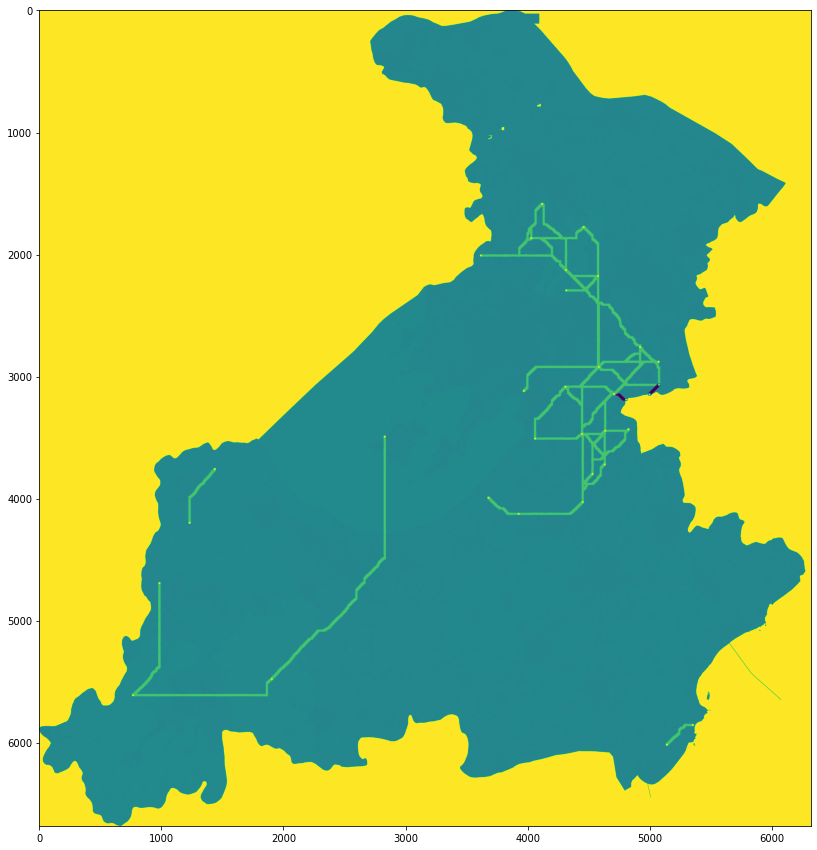

In [24]:
final_input = points_of_interests[["rank", "start", "end"]].astype(int)
final_input["start_cord"] = final_input["start"].map(mapping_dict) 
final_input["end_cord"] = final_input["end"].map(mapping_dict) 

idx = 0

plot = MESC.copy()
output_tiff = np.zeros_like(plot)

for start, end in zip(final_input["start_cord"], final_input["end_cord"]):
    start = [int(x) for x in start]
    end = [int(x) for x in end]
    
    path_pool, mesc_val_pool, flags = fast_main(MESC, ECR, start, end, path_max=1, lt_padding=[300, 300], rb_padding=[300, 300])
    print(flags, start, end)
    
    if "Success" in flags:
        path_pool = [path for path, flag in zip(path_pool, flags) if flag=="Success"]
        mesc_val_pool = [mesc_val for mesc_val,flag in zip(mesc_val_pool, flags) if flag=="Success"]
        flags = [flag for flag in flags if flag=="Success"]
        
    
    
    
    if "Success" in flags:
        plot = __add_path_visualize(plot, path_pool, width=10, color=60, visualize=False)
    else:
        plot = __add_path_visualize(plot, path_pool, width=10, color=150, visualize=False)
    
    output_tiff = __add_path_tiff(output_tiff, path_pool, color=1, visualize=False)


fig = __add_path_visualize(plot, [], width=20, color=100, visualize=True)



In [25]:
path = './../results/2.4.4/landscape_roads.tif'
write_data_to_tif(output_tiff, path)